In [54]:
## import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
from datetime import datetime
from dateutil.relativedelta import relativedelta


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.regression.linear_model import OLS

# for mean-variance portfolio
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt.risk_models import CovarianceShrinkage

# ploting initiation
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [3]:
## data extraction
zip_path = "data/Data-20240401.zip"

with zipfile.ZipFile(zip_path, 'r') as zip:
    zip.extractall(path='data/')

FF5 = pd.read_csv('data/FF5_2000_2022.csv')
CRSP = pd.read_csv('data/CRSP_2000_2022.csv')
PS = pd.read_csv('data/PS_2000_2022.csv')
HXZ5 = pd.read_csv('data/HXZ5_2000_2022.csv')

In [4]:
CRSP.describe()
# CRSP.loc[CRSP['PERMNO'] == 10324]
# PERMNO: unique identifier for each stock
# MthPrc: monthly price
# MthRet: monthly total return

PERMNO         YYYYMM         MthPrc        MthRet
count  82060.000000   82060.000000   82060.000000  82060.000000
mean   66283.527785  201170.300122     740.232815      0.010618
std    30504.956059     648.832262   12209.984685      0.075130
min    10324.000000  200001.000000       5.750000     -0.949125
25%    39642.000000  200610.000000      65.190000     -0.022705
50%    83799.000000  201205.000000      93.820000      0.008606
75%    89959.000000  201709.000000     134.390000      0.043259
max    93436.000000  202212.000000  528921.000000      1.847460

In [5]:
len(CRSP['PERMNO'].unique())

573

In [6]:
FF5.tail()
# FF5.describe()
# Mkt-RF: excess return on the market
# SMB: (Small Minus Big) is the average return on the nine small stock portfolios minus the average return on the nine big stock portfolios
# HML: (High Minus Low) is the average return on the two value portfolios minus the average return on the two growth portfolios
# RMW: (Robust Minus Weak) is the average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios,
# CMA: (Conservative Minus Aggressive) is the average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios,

YYYYMM  Mkt-RF   SMB   HML   RMW   CMA    RF
271  202208   -3.77  1.51  0.31 -4.80  1.30  0.19
272  202209   -9.35 -1.00  0.03 -1.50 -0.85  0.19
273  202210    7.83  1.87  8.05  3.07  6.56  0.23
274  202211    4.60 -2.68  1.39  6.02  3.11  0.29
275  202212   -6.41 -0.13  1.36  0.08  4.18  0.33

In [7]:
HXZ5.tail()
# HXZ5.describe()
# R_ME: the size factor returns
# R_IA: the investment factor returns
# R_ROE: the return on equity factor returns
# R_EG: the expected growth factor returns.

R_F   R_MKT    R_ME    R_IA   R_ROE    R_EG  YYYYMM
271  0.1901 -3.7735  1.4291  2.7381 -2.7978 -3.5470  202208
272  0.1929 -9.3458 -1.6943 -0.2182  1.1517  1.7172  202209
273  0.2327  7.8326  4.6904  7.4110  5.3826 -0.9359  202210
274  0.2856  4.6082 -2.3226  2.1779  2.3981  1.2883  202211
275  0.3379 -6.4054  0.2797  3.8672 -0.5108 -0.3618  202212

In [8]:
PS.tail()
# PS.describe()
# AggLiq: Aggregate liquidity level
# eq8: Innovations in aggregated liquidity
# LIQ_V: Traded liquidity factor

YYYYMM    AggLiq       eq8     LIQ_V
259  202108  0.012418  0.032290  0.003736
260  202109 -0.016866 -0.006602 -0.012899
261  202110 -0.006214 -0.008326  0.015679
262  202111  0.014166  0.030774 -0.026395
263  202112  0.060568  0.070741 -0.023452

In [9]:
## Data preparation

# stock return
CRSP['date'] = pd.to_datetime(CRSP['YYYYMM'], format='%Y%m')
ret_data = CRSP.set_index('date').drop(['YYYYMM','MthPrc'],axis=1)

# factors
factors_data = (FF5
            .merge(HXZ5, on='YYYYMM')
            .merge(PS, on='YYYYMM',how='left')
            .drop(columns=['R_MKT','R_F','RF'])
)
factors_data['date'] = pd.to_datetime(factors_data['YYYYMM'], format='%Y%m')
factors_data = factors_data.set_index('date').drop('YYYYMM',axis=1)

# name of factors
exog_vars = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG', 'AggLiq', 'eq8', 'LIQ_V']

# whole dataframe
df = ret_data.merge(factors_data,how='left',on='date')
df_filtered = df.groupby('PERMNO').filter(lambda x: len(x) > 60)
stocks = df_filtered['PERMNO'].unique()

In [10]:
len(df_filtered['PERMNO'].unique())

390

# 1 (Navie) Factor Regression
rolling-window regression:$$R_{i,t} = \alpha + \sum \beta_{i,j} F_{j,t} + \varepsilon_{i,t}$$

In [11]:
## Rolling window regression for the eligible stocks
# Data preparation
y = df.loc[df['PERMNO'] == 10324, ['MthRet']]
exog = sm.add_constant(df.loc[df['PERMNO'] == 10324, exog_vars])

# Regression
rres = RollingOLS(y['MthRet'], exog, window=60).fit()

# parameters
# params = rres.params.copy()
# params

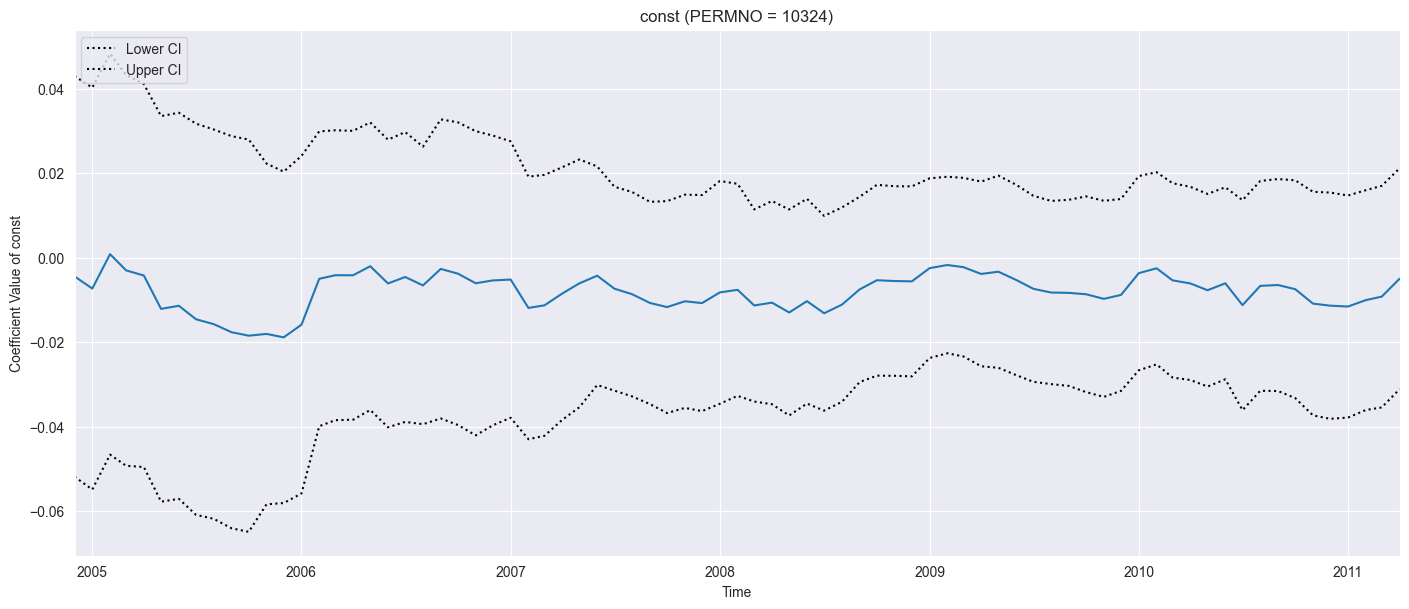

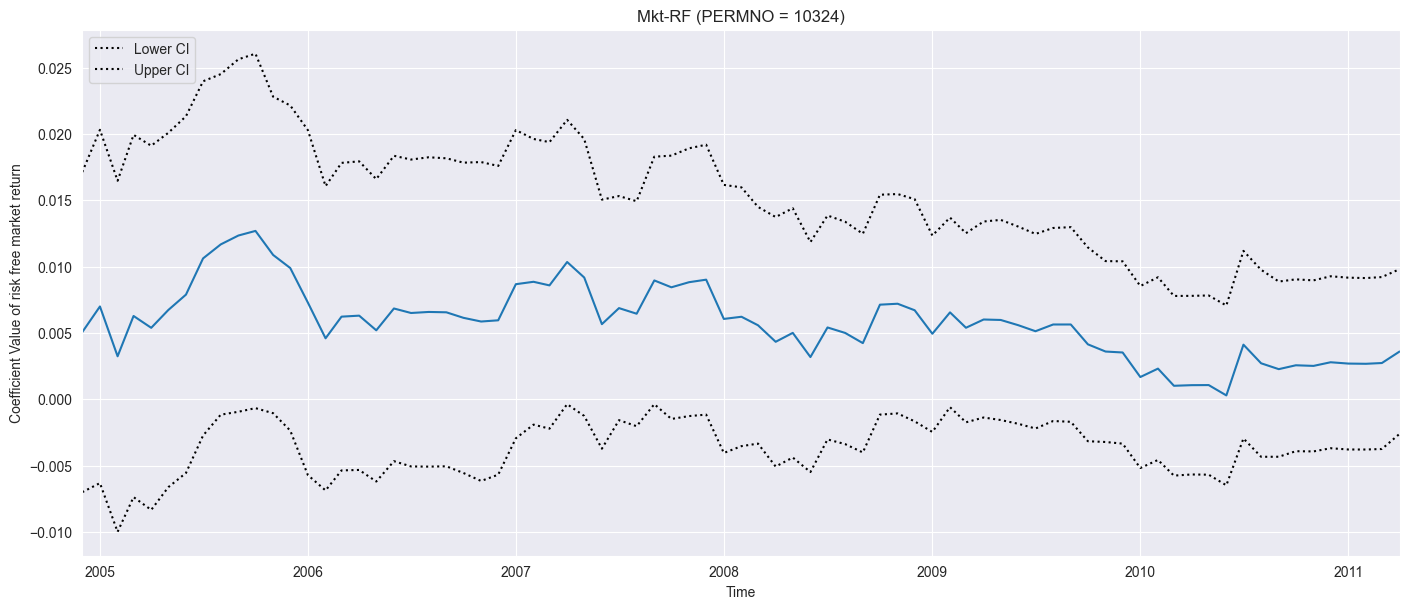

In [12]:
## time series plot and 95% CI of const and risk free market return
fig = rres.plot_recursive_coefficient(variables=['const'], figsize=(14, 6))
plt.ylabel('Coefficient Value of const')
plt.xlabel('Time')
plt.title('const (PERMNO = 10324)')
fig.savefig('fig/const_naive_coeff.png')

fig = rres.plot_recursive_coefficient(variables=['Mkt-RF'], figsize=(14, 6))
plt.ylabel('Coefficient Value of risk free market return')
plt.xlabel('Time')
plt.title('Mkt-RF (PERMNO = 10324)')
fig.savefig('fig/mktrf_naive_coeff.png')

# 2 Fama-MacBeth Regression

In [13]:
## first stage time series reg
params = pd.DataFrame()
for stock in stocks:
    y = df.loc[df['PERMNO'] == stock, ['MthRet']]
    exog = sm.add_constant(df.loc[df['PERMNO'] == stock, exog_vars])
    rres = RollingOLS(y['MthRet'], exog, window=60).fit()
    param_temp = rres.params
    param_temp['PERMNO'] = stock
    params = pd.concat([params, param_temp])


In [14]:
# data preparation for cross-sectional reg
beta = params.drop(columns='const')
y = df_filtered[['PERMNO','MthRet']]
temp = y.set_index('PERMNO', append=True).swaplevel()
fmdata = (pd.merge(temp.dropna().reset_index(),beta.reset_index(),on=['PERMNO','date'])
            .set_index('date')
            .dropna()
            .reset_index()
            .sort_values(['date'])
)
months = fmdata['date'].unique()

In [15]:
## second stage cross-sectional reg
gamma = pd.DataFrame()
for mon in months:
    y = fmdata.loc[fmdata['date']==mon,'MthRet']
    exog = sm.add_constant(fmdata.loc[fmdata['date']==mon, exog_vars])
    rres = OLS(y, exog).fit()
    temp = rres.params
    temp.name = mon
    gamma = pd.concat([gamma, temp],axis=1)

gamma = np.transpose(gamma)

/var/folders/4l/mjqp680s3ld1jxwcfps_43800000gn/T/ipykernel_65577/3101323842.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  gamma = pd.concat([gamma, temp],axis=1)


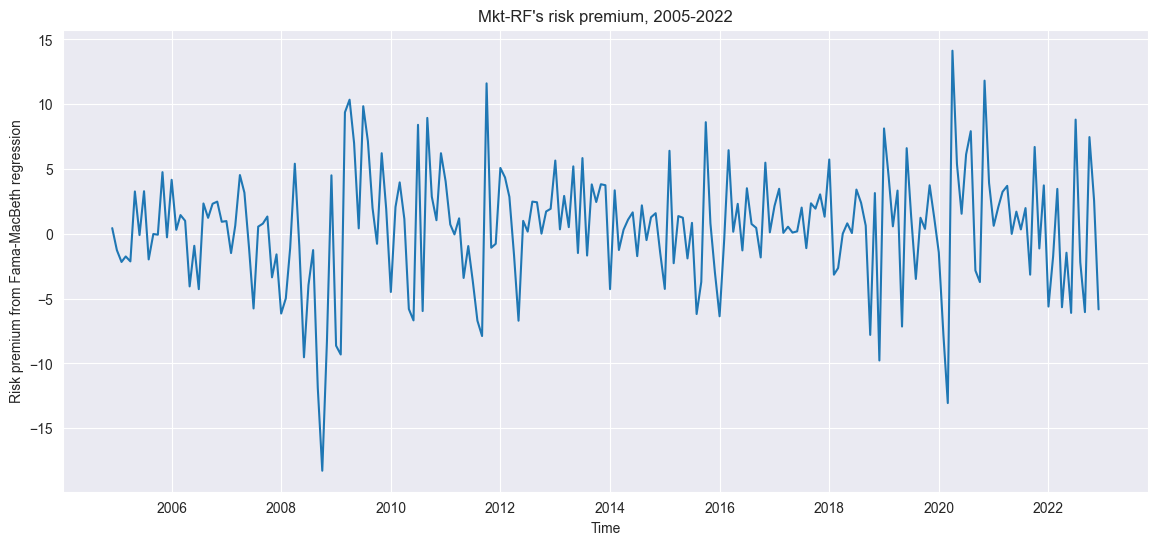

In [16]:
## visualization
fig = plt.figure(figsize=(14, 6))
plt.plot(gamma.index, gamma['Mkt-RF'])
plt.xlabel('Time')
plt.ylabel('Risk premium from Fama-MacBeth regression')
plt.title("Mkt-RF's risk premium, 2005-2022")
fig.savefig('fig/mktrf_fm_riskp.png')

# 3 LASSO Regression

In [30]:
## Data preparation
# Create lags
lag_periods = range(1,7)  # Lag periods from 0 to 6 months
exog_vars_LASSO = exog_vars

# Iterate over each factor column
df_LASSO = df_filtered
columns = df_LASSO.columns
for column in columns:
    if column not in ['PERMNO','MthRet']:  
        # Create lagged columns for each lag period
        for lag in lag_periods:
            df_LASSO[f'{column}-l{lag}'] = df_LASSO[column].shift(lag)
            exog_vars_LASSO.append(f'{column}-l{lag}')

# date list
datelist = pd.date_range('2005-1-1','2020-1-1',freq='YS').tolist()

# data for LASSO
df_LASSO = df_LASSO.reset_index(drop=False)

/var/folders/4l/mjqp680s3ld1jxwcfps_43800000gn/T/ipykernel_65577/2068242671.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_LASSO[f'{column}-l{lag}'] = df_LASSO[column].shift(lag)
/var/folders/4l/mjqp680s3ld1jxwcfps_43800000gn/T/ipykernel_65577/2068242671.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_LASSO[f'{column}-l{lag}'] = df_LASSO[column].shift(lag)
/var/folders/4l/mjqp680s3ld1jxwcfps_43800000gn/T/ipykernel_65577/2068242671.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

In [31]:
## simple LASSO
window = 60
alpha = 0.01
error=pd.DataFrame()
params=pd.DataFrame()
coef=pd.DataFrame()
for date in datelist:
    start_date = date + relativedelta(months=-window)
    for stock in stocks:
        df_temp = df_LASSO.loc[(df_LASSO['PERMNO'] == stock) & ((df_LASSO['date'] <= date) & (df_LASSO['date'] > start_date))].dropna()
        y = df_temp['MthRet']
        X = df_temp[exog_vars_LASSO]
        try:
            rres = Lasso(alpha=alpha).fit(X,y)
            temp_params = rres.coef_
            temp_params = pd.DataFrame(temp_params.reshape(-1,len(temp_params)),columns=exog_vars_LASSO)
            temp_params['date'] = date
            temp_params['PERMNO'] = stock
            params = pd.concat([params,temp_params])
        except:
            temp_error = pd.DataFrame({'date':date,'PERMNO':stock},index=[0])
            error = pd.concat([error,temp_error])
params = params.set_index('PERMNO')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

In [34]:
df_LASSO[df_LASSO['PERMNO'] == 12289]

date  PERMNO    MthRet  Mkt-RF   SMB   HML   RMW   CMA    R_ME  \
2633 2010-09-01   12289  0.011627    9.54  3.77 -3.18 -0.18  0.36  3.9493   
2634 2010-10-01   12289  0.005066    3.88  0.86 -2.51  1.31 -0.33  0.6884   
2635 2010-11-01   12289 -0.009152    0.60  3.64 -0.92  0.38  1.63  3.6487   
2636 2010-12-01   12289 -0.011574    6.82  0.99  3.76 -3.52  3.21  0.4459   
2637 2011-01-01   12289  0.001209    1.99 -2.38  0.75 -0.65  0.77 -2.0115   
...         ...     ...       ...     ...   ...   ...   ...   ...     ...   
2776 2022-08-01   12289 -0.034747   -3.77  1.51  0.31 -4.80  1.30  1.4291   
2777 2022-09-01   12289 -0.045800   -9.35 -1.00  0.03 -1.50 -0.85 -1.6943   
2778 2022-10-01   12289 -0.010373    7.83  1.87  8.05  3.07  6.56  4.6904   
2779 2022-11-01   12289  0.052155    4.60 -2.68  1.39  6.02  3.11 -2.3226   
2780 2022-12-01   12289 -0.008560   -6.41 -0.13  1.36  0.08  4.18  0.2797   

        R_IA  ...  LIQ_V-l5-l3  LIQ_V-l5-l4  LIQ_V-l5-l5  LIQ_V-l5-l6  \
2633  1.1572  ...     0.021153     0.003149    -0.003507     0.014905   
2634 -0.0067  ...     0.042320     0.021153     0.003149    -0.003507   
2635  1.8594  ...     0.002370     0.042320     0.021153     0.003149   
2636  3.0261  ...     0.025770     0.002370     0.042320     0.021153   
2637  1.3160  ...    -0.016733     0.025770     0.002370     0.042320   
...      ...  ...          ...          ...          ...          ...   
2776  2.7381  ...    -0.023452    -0.026395     0.015679    -0.012899   
2777 -0.2182  ...          NaN    -0.023452    -0.026395     0.015679   
2778  7.4110  ...          NaN          NaN    -0.023452    -0.026395   
2779  2.1779  ...          NaN          NaN          NaN    -0.023452   
2780  3.8672  ...          NaN          NaN          NaN          NaN   

      LIQ_V-l6-l1  LIQ_V-l6-l2  LIQ_V-l6-l3  LIQ_V-l6-l4  LIQ_V-l6-l5  \
2633     0.042320     0.021153     0.003149    -0.003507     0.014905   
2634     0.002370     0.042320     0.021153     0.003149    -0.003507   
2635     0.025770     0.002370     0.042320     0.021153     0.003149   
2636    -0.016733     0.025770     0.002370     0.042320     0.021153   
2637    -0.000404    -0.016733     0.025770     0.002370     0.042320   
...           ...          ...          ...          ...          ...   
2776          NaN    -0.023452    -0.026395     0.015679    -0.012899   
2777          NaN          NaN    -0.023452    -0.026395     0.015679   
2778          NaN          NaN          NaN    -0.023452    -0.026395   
2779          NaN          NaN          NaN          NaN    -0.023452   
2780          NaN          NaN          NaN          NaN          NaN   

      LIQ_V-l6-l6  
2633     0.002851  
2634     0.014905  
2635    -0.003507  
2636     0.003149  
2637     0.021153  
...           ...  
2776     0.003736  
2777    -0.012899  
2778     0.015679  
2779    -0.026395  
2780    -0.023452  

[148 rows x 519 columns]

In [33]:
error['PERMNO'].unique()

array([12289, 12294, 12295, 12296, 12297, 12301, 12302, 12303, 12304,
       12305, 12308, 12313, 12314, 12316, 12317, 12318, 12321, 12373,
       12449, 12453, 12623, 12742, 12874, 12975, 13126, 13300, 13394,
       13407, 13447, 13511, 13623, 13624, 13628, 13781, 13851, 13911,
       14282, 14377, 14404, 14542, 14627, 14714, 14888, 15102, 15395,
       15649, 15694, 15735, 15919, 16167, 16327, 16559, 16968, 17279,
       89992, 89993, 89995, 89996, 89997, 89998, 89999, 90000, 90001,
       90002, 90003, 90004, 90005, 90111, 90257, 90258, 90259, 90260,
       90261, 90263, 90264, 90265, 90319, 90347, 90348, 90349, 90448,
       90694, 90857, 90880, 90992, 90993, 91006, 91007, 91047, 91053,
       91068, 91124, 91147, 91152, 91221, 91225, 91226, 91227, 91233,
       91290, 91291, 91292, 91293, 91294, 91295, 91308, 91424, 91483,
       91589, 91592, 91699, 91700, 91701, 91702, 91703, 91704, 91705,
       91706, 91747, 91818, 91873, 91877, 91878, 91933, 91948, 91949,
       91950, 91952,

In [19]:
## top 5 factors each period
# aggregation by period
para = params.groupby('date').agg(lambda x: np.count_nonzero(x)).reset_index(drop=False)
para

# top 5 factors
params_star = pd.DataFrame()
for date in datelist:
    temp = para.loc[para['date'] == date]
    temp = temp.drop(columns='date').sort_values(by=temp.index.values[0],axis=1,ascending=False).columns[:5].values
    temp = pd.DataFrame(temp).T
    temp['date'] = date
    params_star = pd.concat([params_star,temp],axis=0)
params_star = params_star.set_index('date')
params_star.columns=['1st','2nd','3rd','4th','5th']
params_star.index = params_star.index.strftime("%Y%m")

In [20]:
# params_star = params_star.replace({'_':'-'})
params_star.to_latex('top_5_factor_LASSO.tex',caption='Top 5 factors selected by LASSO each period',label='tab:top5factor')

In [27]:
params

Empty DataFrame
Columns: []
Index: []

# 4 Mean-Variance Portfolio

Investor choses asset allocation weights $w$ to maximize mean-variance reward function $$R(w) = w^T \mu - \frac{\gamma}{2}w^T \Sigma w$$
The policy optimization problem is solved by performing the prediction-decision process.

In [22]:
# Data preparation
params_star.index = pd.to_datetime(params_star.index, format='%Y%m')

In [70]:
window = 60
gamma = 1
error_portfolio=pd.DataFrame()
mean = pd.DataFrame()
expected_ret = pd.DataFrame()
sharpe = pd.DataFrame()
volatility = pd.DataFrame()
c = 0.2 # cut-off return
for date in datelist:
    start_date = date + relativedelta(months=-window)

    df_temp = df_LASSO.loc[((df_LASSO['date'] <= date) & (df_LASSO['date'] > start_date))].fillna('bfill')
    prices = df_temp[['MthRet','date','PERMNO']].pivot(index='date',columns='PERMNO').fillna(0)
    mu = mean_historical_return(prices)
    S = CovarianceShrinkage(prices).ledoit_wolf()

    ef = EfficientFrontier(mu, S)
    weights = ef.max_quadratic_utility(risk_aversion=gamma)
    expected_ret[date], volatility[date], sharpe[date] = ef.portfolio_performance()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/expected_returns.py:36: UserWarning: Some returns are infinite. Please check your price data.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce


ValueError: Input contains NaN.

In [69]:
prices

MthRet                                                    \
PERMNO         10324     10777     10933     11415     11587     11762   
date                                                                     
2000-02-01  0.104567  0.059548 -0.202744  0.192488  0.150000  0.055695   
2000-03-01 -0.127312 -0.121096  0.112811 -0.118110  0.000000  0.040867   
2000-04-01 -0.026185  0.117875 -0.003436  0.028274  0.048913  0.076923   
2000-05-01  0.163892 -0.049505 -0.007328  0.247467 -0.015544 -0.131417   
2000-06-01  0.046205 -0.004390 -0.016066  0.247680  0.042105 -0.076658   
2000-07-01  0.168244  0.025210  0.091792  0.205021  0.045455  0.012127   
2000-08-01  0.081008  0.078893 -0.056589  0.314815 -0.062802 -0.014990   
2000-09-01 -0.091590  0.091442  0.040274 -0.066021  0.036082 -0.071563   
2000-10-01  0.041247  0.034061 -0.045305 -0.048068 -0.104478  0.104462   
2000-11-01  0.236796 -0.012669  0.027610 -0.044554  0.055556  0.036791   
2000-12-01  0.024199  0.108761  0.215785  0.209326  0.242105  0.072193   
2001-01-01 -0.037526  0.077399 -0.089779  0.002913 -0.008475  0.053785   
2001-02-01  0.015884  0.081897  0.091047 -0.239918 -0.025641  0.040739   
2001-03-01  0.027207  0.091941  0.040334  0.028237  0.043860 -0.037245   
2001-04-01  0.206354 -0.080000  0.049465  0.013644  0.495798  0.074599   
2001-05-01 -0.018629 -0.008484 -0.002548  0.229853 -0.094382  0.068750   
2001-06-01  0.140827  0.163451  0.003831 -0.029044  0.136476 -0.103581   
2001-07-01 -0.081967 -0.073641  0.030076  0.241040 -0.006550  0.047646   
2001-08-01  0.011429  0.016914 -0.086409 -0.024918 -0.000440 -0.014737   
2001-09-01 -0.198093 -0.183851  0.054510 -0.055887  0.017150 -0.176839   
2001-10-01  0.187803  0.129944  0.004872 -0.079180  0.500649  0.105219   
2001-11-01  0.012419 -0.014681 -0.064710  0.003434 -0.013253  0.070853   
2001-12-01  0.095936  0.058174 -0.019752  0.086379  0.110949  0.068956   
2002-01-01 -0.238055  0.031202  0.073755 -0.080141 -0.080158 -0.005241   
2002-02-01 -0.026968 -0.007937  0.031623 -0.065068 -0.127974  0.097309   
2002-03-01 -0.015998  0.032154  0.022663 -0.035604 -0.097667  0.002973   
2002-04-01 -0.062514  0.060606  0.071200  0.012610  0.009946  0.044826   
2002-05-01 -0.217636  0.018773 -0.040550 -0.001650  0.126056 -0.039917   
2002-06-01 -0.399313 -0.003647 -0.058137 -0.045236 -0.112069 -0.099852   
2002-07-01  0.183992 -0.063794  0.027919 -0.039824 -0.244876 -0.040275   
2002-08-01 -0.092186  0.045444  0.030370  0.159180 -0.034762  0.019666   
2002-09-01 -0.003385 -0.045389 -0.045387 -0.119078 -0.085348 -0.098954   
2002-10-01  0.351286 -0.032227  0.016618 -0.055547  0.097087  0.079856   
2002-11-01  0.177738  0.003508 -0.017235  0.122387  0.064651  0.109373   
2002-12-01 -0.098476 -0.032470  0.032663 -0.014236  0.039021  0.029524   
2003-01-01  0.091985 -0.057971 -0.010219  0.214472 -0.042222 -0.084276   
2003-02-01 -0.034376  0.025385  0.050442 -0.014421  0.025522 -0.001829   
2003-03-01  0.169019  0.011345  0.046991  0.097420  0.033937 -0.014094   
2003-04-01  0.104801  0.033691  0.083371 -0.024561  0.064770  0.173267   
2003-05-01  0.176807  0.044623  0.040850 -0.051259  0.106453  0.028207   
2003-06-01 -0.116691 -0.004876  0.014866  0.241706  0.028603 -0.063386   
2003-07-01  0.205925  0.150154  0.056602  0.031298  0.191766  0.076835   
2003-08-01 -0.066363 -0.075537 -0.006433  0.001776  0.076970  0.112510   
2003-09-01 -0.017399 -0.011683 -0.006512  0.007980  0.275791 -0.053610   
2003-10-01 -0.008853  0.078524 -0.054719  0.125495 -0.030973  0.136552   
2003-11-01  0.016340 -0.039298  0.019256  0.075160  0.098658  0.027434   
2003-12-01  0.056592  0.102788 -0.014538 -0.067725 -0.053333  0.048451   
2004-01-01  0.111382 -0.020581  0.070530 -0.021572 -0.036092  0.075662   
2004-02-01 -0.079043  0.058888  0.002837  0.028158  0.016210  0.012647   
2004-03-01 -0.072745 -0.013470  0.057834 -0.110580 -0.082232 -0.040143   
2004-04-01 -0.070115 -0.004065  0.017749 -0.097603  0.110702  0.056772   
2004-05-01  0.0080

In [ ]:
        # beta_vars = params_star.loc[date].values
        # beta_temp = params.loc[((params['date'] <= date) & (params['date'] > start_date))].loc[stock,beta_vars]
        # df_temp = df_LASSO.loc[(df_LASSO['PERMNO'] == stock) & ((df_LASSO['date'] <= date) & (df_LASSO['date'] > start_date))].dropna()
        # y = df_temp['MthRet']
        # X = df_temp[beta_vars]
        # y_hat = X.T.dot(beta_temp)
        # eps = y - y_hat

In [ ]:

# beta_vars = params_star.loc[date].values
# beta_temp = params.loc[(df_LASSO['PERMNO'] == stock) & ((df_LASSO['date'] <= date) & (df_LASSO['date'] > start_date))].loc[stock,beta_vars]
df_temp = df_LASSO.loc[((df_LASSO['date'] <= date) & (df_LASSO['date'] > start_date))]
prices = df_temp[['MthRet','date','PERMNO']].pivot(index='date',columns='PERMNO')
mu = mean_historical_return(prices)
S = sample_cov(prices)

ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
weights = ef.max_sharpe()
# max_quadratic_utility(risk_aversion=gamma)
expected_ret[date], volatility[date], sharpe[date] = ef.portfolio_performance()

        
        


In [40]:
mu

        PERMNO
MthRet  10324    -9.999999e-01
        10777              NaN
        10933    -9.931228e-01
        11415    -9.981458e-01
        11587              NaN
                      ...     
        90348    -2.676971e+35
        90349    -4.087403e+96
        90448     1.690248e+42
        90878     4.105288e+01
        92655              NaN
Length: 260, dtype: float64

In [ ]:
# Decision process


In [ ]:
# Rolling window testing approach